<a href="https://www.kaggle.com/code/iqmansingh/spam-or-ham-sms-classifier-nlp?scriptVersionId=135491213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://cdn.discordapp.com/attachments/1111599839663370271/1124998582316056627/SMS-SPam.jpg">

# **Creating a Spam SMS Classifier**

---

# Importing Libraries

In [79]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import datetime
import warnings
import nltk
import random
import re
import sklearn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

nltk.download('punkt',download_dir="/kaggle/working/")
nltk.download('wordnet',download_dir="/kaggle/working/")
nltk.download('stopwords',download_dir="/kaggle/working/")
nltk.data.path.append('/kaggle/working/') 
with zipfile.ZipFile("/kaggle/working/corpora/wordnet.zip", 'r') as zip_f:
    zip_f.extractall("/kaggle/working/corpora/")
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline
sns.set_style("dark")

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
spam_data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')
spam_data.columns = ["target","messages","a","b","c"]
spam_data.drop(["a","b","c"],inplace=True,axis=1)
spam_data.head()

,target,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preprocessing
#### 1. Tokenization
#### 2. Lemmatization
#### 3. Lowering the aplhabets
#### 4. Removing Special Chars

In [40]:
stopwords = nltk.corpus.stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def textProcess(text):
    words = nltk.word_tokenize(text)
    words = [re.sub("[^a-zA-Z0-9]","",i).lower().strip() for i in words]
    words = [lemmatizer.lemmatize(i) for i in words if i not in stopwords]
    text = " ".join(words)
    return text

In [42]:
spam_data["messages"] = spam_data["messages"].apply(textProcess)
spam_data.head()

,target,messages
0,ham,go jurong point crazy available bugis n great...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah nt think go usf life around though


In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
spam_data["target"] = encoder.fit_transform(spam_data["target"])
# 0 = ham
# 1 = spam

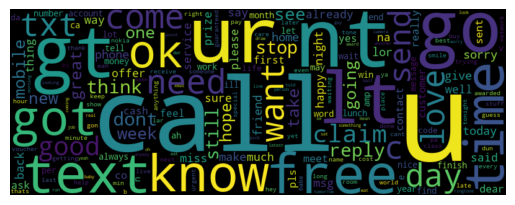

In [78]:
text = "".join(spam_data["messages"][i] for i in range(1000))
word_cloud = WordCloud(collocations = False, background_color = 'black',height=300,width=800).generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off");

# TF-IDF (Term Frequency - Inverse Document Frequency)

In [44]:
spam_data.shape

(5572, 2)

In [45]:
tfidfVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=2500)
df = pd.DataFrame(tfidfVectorizer.fit_transform(spam_data["messages"]).toarray())
spam_data = pd.concat((spam_data,df),axis=1)
spam_data.shape

(5572, 2502)

# Training Model

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

cols = [i for i in spam_data.columns if i!="messages" and i!="target"]
seed = np.random.seed(6)

X = spam_data[cols]
y = spam_data["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

In [47]:
xgb_model = XGBClassifier(n_estimators=1000,learning_rate=0.05,seed=seed,tree_method='gpu_hist')
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [48]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train,y_train)

MultinomialNB()

# Evaluating the Models
#### 1. XGB Model

----------------------------------------------------------------------------------------------------
Accuracy: 0.9727207465900933
Precision: 0.9453551912568307
ROC AUC: 0.9702055995191826
----------------------------------------------------------------------------------------------------


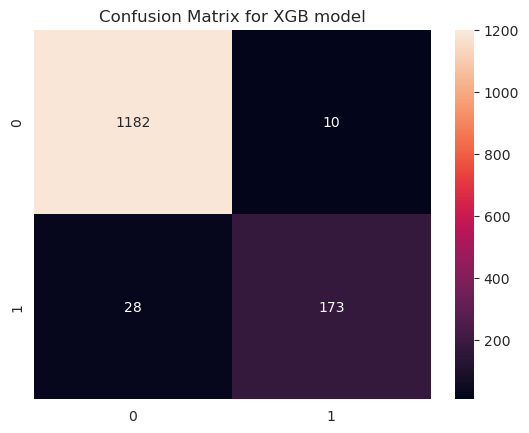

In [49]:
print("-"*100)
print("Accuracy:",accuracy_score(y_test,xgb_model.predict(X_test)))
print("Precision:",precision_score(y_test,xgb_model.predict(X_test)))
print("ROC AUC:",roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))
print("-"*100)
cnf_matrix = confusion_matrix(y_test,xgb_model.predict(X_test))
sns.heatmap(cnf_matrix,annot=True,vmax=1200,cmap="rocket",fmt=".5g")
plt.title("Confusion Matrix for XGB model");

#### 2. Multinomial Naive Bayes Model

----------------------------------------------------------------------------------------------------
Accuracy: 0.9770279971284996
Precision: 0.9941520467836257
ROC AUC: 0.9853083575411533
----------------------------------------------------------------------------------------------------


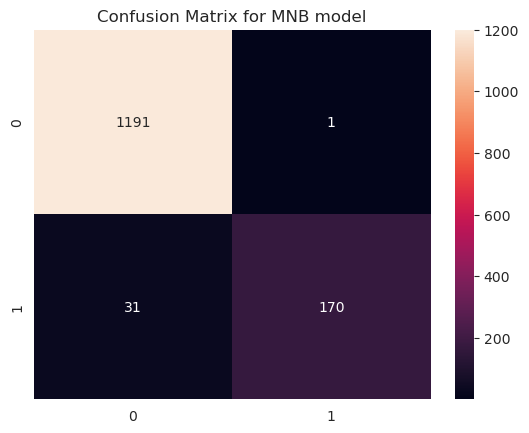

In [50]:
print("-"*100)
print("Accuracy:",accuracy_score(y_test,mnb_model.predict(X_test)))
print("Precision:",precision_score(y_test,mnb_model.predict(X_test)))
print("ROC AUC:",roc_auc_score(y_test, mnb_model.predict_proba(X_test)[:,1]))
print("-"*100)
cnf_matrix = confusion_matrix(y_test,mnb_model.predict(X_test))
sns.heatmap(cnf_matrix,annot=True,vmax=1200,cmap="rocket",fmt=".5g")
plt.title("Confusion Matrix for MNB model");